In [1]:
# import statements
import math
from autograd import numpy as np
import scipy as scp
from autograd import grad 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad 
from autograd import hessian
from autograd.misc.flatten import flatten_func
from autograd import value_and_grad 
from matplotlib import gridspec
from matplotlib import cm
%matplotlib inline

In [2]:
def RedfieldTensor(omega_c,gamma_i,H_S,tau_3,kbT):
    import math
    from autograd import numpy as np
    pi  = math.pi
    
    def deltafxn(x,y):
        if x == y:
            return 1
        else:
            return 0
        
    Nw = int(1e3)
    domega = 10
    omega = np.arange(domega,(Nw)*domega,domega)
    theta = kbT
    t = tau_3
    dt = np.abs(tau_3[1]-tau_3[0])
    M = len(H_S)
    [E,V_S] = np.linalg.eigh(H_S); 
    JJ = []
    for i in range(M):
        A = gamma_i[i]*omega**3*np.exp(-omega/omega_c[i])/(pi*omega_c[i]**2)
        JJ.append(A)
    Y = np.zeros(shape=(M,M,Nw,Nt),dtype=complex);
    Q = np.zeros(shape=(M,M,M,M,Nt),dtype=complex);
    Rtot = np.zeros(shape=(M,M,M,M),dtype=complex);
    for i in range(M):
        for j in range(M):
            for k in range(Nw-1):
                J = JJ[i]
                Y[i,j,k,:] = deltafxn(i,j)*( J[k]*(np.cos(omega[k]*t)*(np.tanh(omega[k]/2/theta))**(-1) - 1j*np.sin(omega[k]*t)) ); 
    for alpha in range(M):
        for beta in range(M):
            for gamma in range(M):
                for delta in range(M):
                    Temp = 0
                    for n in range(M):
                        for m in range(M):
                            A = np.squeeze(np.sum(Y[n,m,:,:],0))
                            Temp  = Temp + np.conj(V_S[n,alpha])*V_S[n,beta]*np.conj(V_S[m,gamma])*V_S[m,delta]*A*domega;
                    Q[alpha,beta,gamma,delta,:] = Temp;
    for alpha in range(M):
        for beta in range(M):
            for gamma in range(M):
                for delta in range(M):
                    R1temp = 0
                    R4temp = 0
                    for eta in range(M):
                        R1temp = R1temp + np.sum(np.exp(-1j*(E[eta] - E[gamma])*t)*np.squeeze(Q[gamma,eta,eta,alpha,:]));
                        R4temp = R4temp + np.sum(np.exp(-1j*(E[delta] - E[eta])*t)*np.squeeze(np.conj(Q[delta,eta,eta,beta,:])));
                    R1v = deltafxn(beta,delta)*R1temp; 
                    R4v = deltafxn(gamma,alpha)*R4temp;
                    R2v = np.sum(np.exp(-1j*(E[delta] - E[beta])*t)*np.squeeze(np.conj(Q[delta,beta,gamma,alpha,:])));
                    R3v = np.sum(np.exp(-1j*(E[alpha] - E[gamma])*t)*np.squeeze(Q[gamma,alpha,delta,beta,:])); 
                    Rtot[alpha,beta,gamma,delta] = -1j*(E[gamma] - E[delta])*deltafxn(alpha,gamma)*deltafxn(delta,beta) - (R1v - R2v - R3v + R4v)*dt;
    Red_exc = Rtot
    return Red_exc, JJ, omega

def RK4_integrate_rho(Rtot,H_S,teval,x0_site):
    import math
    from autograd import numpy as np
    
    Nteval = len(teval)
    M = len(H_S)
    E,V_S = np.linalg.eigh(H_S)
    R_rs = np.reshape(Rtot,(M**2,M**2))
    
    rho0 = V_S.T@x0_site@V_S; 
    R_rs = np.reshape(Rtot,(M**2,M**2))
    dteval  = np.abs(teval[1]-teval[0])
    rho_site = np.zeros(shape=(M,M,Nteval),dtype=complex);
    rho_exc = np.zeros(shape=(M,M,Nteval),dtype=complex); 
    rhoM = np.zeros(shape=(M**2,Nteval),dtype=complex);  

    x0 = np.reshape(rho0,(M**2,1))
    rho_site[:,:,0] = rho0_site
    rho_exc[:,:,0] = np.reshape(x0,(M,M))
    rhoM[:,0] = x0.T

    for i in range(1,Nteval):

        #m1 = squeeze(L(teval(i)));
        #m2 = squeeze(L(teval(i)+0.5*dteval));
        #m3 = squeeze(L(teval(i)+0.5*dteval));
        #m4 = squeeze(L(teval(i)+dteval));

        # Fourth-order Runge-Kutta (RK4)
        k1 = dteval*R_rs@x0;
        k2 = dteval*R_rs@(x0+0.5*k1);
        k3 = dteval*R_rs@(x0+0.5*k2);
        k4 = dteval*R_rs@(x0+k3);
        
        x0 = x0 + 1/6*(k1 + 2*k2 + 2*k3 + k4);
        rhoM[:,i] = x0.T
        rho_site[:,:,i] = V_S@np.reshape(rhoM[:,i],(M,M))@V_S.T
        rho_exc[:,:,i] = np.reshape(rhoM[:,i],(M,M))
        
    return rho_exc,rho_site

def plot_rho(taus,omega_bath,rho,JJ,TM):
    # import statements
    import math
    from autograd import numpy as np
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import gridspec
    from matplotlib import cm
    %matplotlib inline
    plt.rcParams.update({'font.size': 22})
    
    M = len(np.squeeze(rho[:,:,0]))

    fig = plt.figure(figsize = (20,8))
    gs = gridspec.GridSpec(1,2) 
    ax1 = plt.subplot(gs[0]); 
    ax2 = plt.subplot(gs[1]); 
    for i in range(M):
        for j in range(M):
            if i == j:
                ax1.plot(taus,np.real(np.squeeze(rho_site[i,i,:])),label=[i+1, i+1])
            else:
                ax2.plot(taus,np.real(np.squeeze(rho_site[i,j,:])),label=[i+1, j+1])
    ax1.grid(True)
    ax1.set_xlabel('t [fs]',Fontsize=17)
    ax1.set_ylabel(r'$\rho_{\mathrm{pop}}(t)$',Fontsize=17)
    ax1.legend(loc=1)
    ax1.set_ylim(0,1)
    ax1.set_xlim(0,np.amax(taus))
    ax1.set_title('Populations',Fontsize=17)
    ax2.grid(True)
    ax2.set_xlabel('t [fs]',Fontsize=17)
    ax2.set_ylabel(r'$\rho_{\mathrm{coh}}(t)$',Fontsize=17)
    ax2.legend(loc=1)
    ax2.set_ylim(-1,1)
    ax2.set_xlim(0,np.amax(taus))
    ax2.set_title('Coherences',Fontsize=17);
    plt.show()
    
    fig2 = plt.figure(figsize = (18,4))
    for i in range(M):
        plt.plot(omega_bath,JJ[i],label=['Site', i]);
    plt.grid(True)
    plt.legend(loc=1)
    plt.xlabel(r'$\omega_{\mathrm{bath}}\,\,\,[cm^{-1}]$',Fontsize=17)
    plt.ylabel(r'$J_i(\omega)$',Fontsize=17)
    plt.title('Spectral Densities',Fontsize=17)
    plt.show()
    
    fig3 = plt.figure(figsize = (18,4))
    for i in range(np.shape(TM)[0]):
        plt.plot(taus,np.real(TM[i,:]),label=i);
    plt.grid(True)
    plt.xlabel(r'$\tau_2\,\,\,[fs]$',Fontsize=17)
    plt.ylabel(r'$T(\tau_2)$',Fontsize=17)
    plt.title('Process Tensor',Fontsize=17)
    plt.xlim(0,np.amax(taus))
    plt.legend(loc=1)
    plt.show()
    
def TM_matrix(R_rs,tau_3,trans):
    import math
    from autograd import numpy as np
    import scipy.linalg as la
    
    #if red == 1:
    #    M = len(R_rs)
    #    R_rs = np.reshape(R_rs,(M**2,M**2))
    if trans == 1:
        R_rs = R_rs.T
    
    M2 = len(R_rs)
    N3 = len(tau_3)
    TM = np.zeros(shape=(M2**2,N3),dtype=complex)
    Ev = np.zeros(shape=(M2,M2,N3),dtype=complex)
    
    for i in range(N3):
        A = la.expm(R_rs*tau_3[i])
        Ev[:,:,i] = A
        TM[:,i] = np.reshape(A,(M2**2,1)).T
    return TM,Ev
    

def ind2D(Ne,a,b):
    from autograd import numpy as np
    va = np.zeros(Ne);
    va[a] = 1;
    vb = np.zeros(Ne);
    vb[b] = 1;

    Vtemp = np.kron(va,vb); 
    J = np.argwhere(Vtemp == 1);
    return J

def pop_pos(Ne):
    from autograd import numpy as np
    posv = np.zeros(shape=(Ne,Ne))
    for a in range(Ne):
        for c in range(Ne):
            b = a; d = c;
            J = ind2D(Ne,a,b);
            K = ind2D(Ne,c,d);
            posv[c,a] = ind2D(Ne**2,J,K);
    pos = np.reshape(posv,(1,Ne**2)); 
    return np.int_(pos),np.int_(posv)


In [3]:
Nt = int(512)
c = 3e-5
dt_fs = 1
dt = 2*math.pi*dt_fs*c
t = np.arange(0,(Nt)*dt,dt)
t = t.T
taus = t/c

J0 = 150
Delta = 150

H_S = np.array([[-Delta, J0],[J0,Delta]]);
E,V_S = np.linalg.eigh(H_S)
VSS = np.kron(V_S,V_S)
VSST = np.kron(V_S.T,V_S.T)

M = len(H_S)
rho0_site = np.zeros(shape=(M,M),dtype=float);
rho0_site[0,0] = 0; rho0_site[0,1] = 0; rho0_site[1,0] = 0; rho0_site[1,1] = 1;

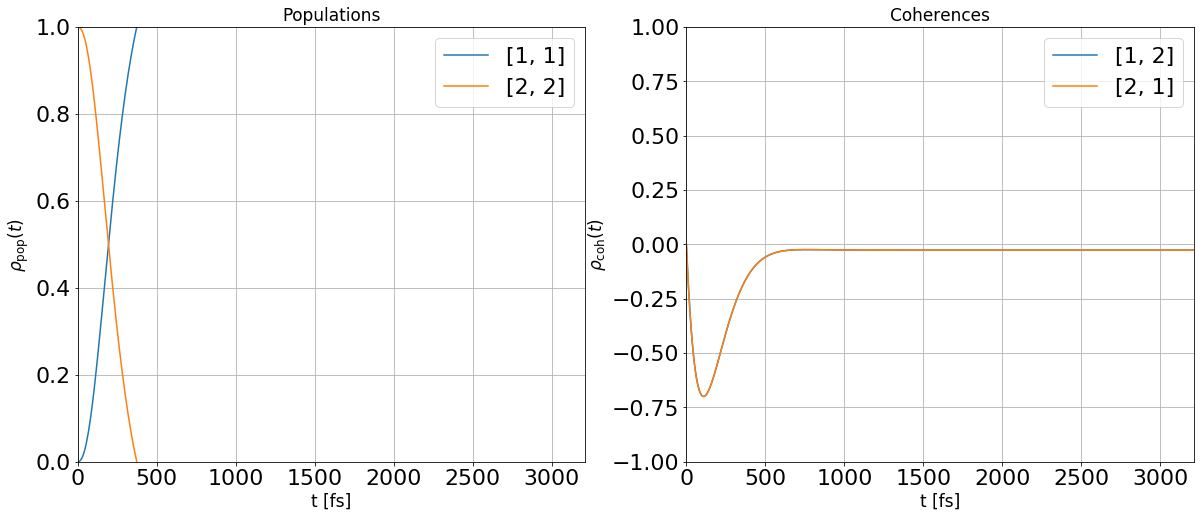

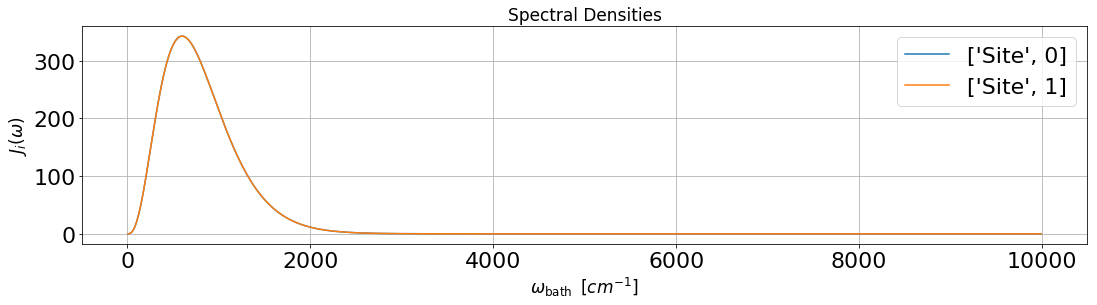

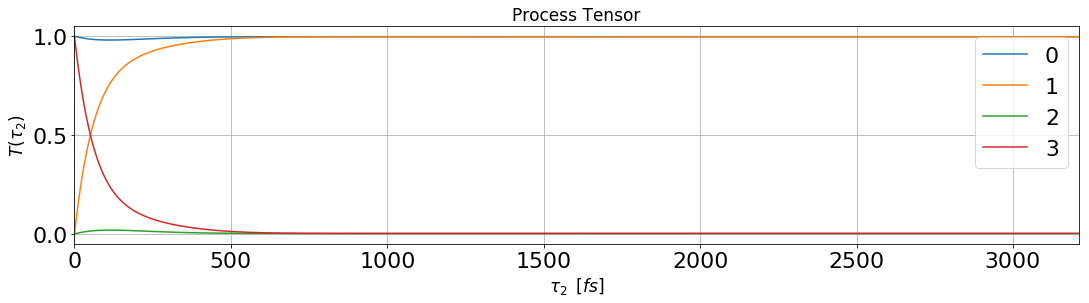

[[ -14.40271261  -14.40677819  -14.40677819  472.122874  ]
 [ -14.40271261 -272.07634967  243.2627933   472.122874  ]
 [ -14.40271261  243.2627933  -272.07634967  472.122874  ]
 [  14.40271261   14.40677819   14.40677819 -472.122874  ]]
[[-8.77750848e-14 -4.38875424e-14  4.38875424e-14  0.00000000e+00]
 [ 1.16947711e+02  3.38790896e+02 -8.54731731e+01 -5.39986353e+01]
 [-1.16947711e+02  8.54731731e+01 -3.38790896e+02  5.39986353e+01]
 [ 0.00000000e+00 -4.38875424e-14  4.38875424e-14 -8.77750848e-14]]


In [5]:
omega_c = np.array([200,200]);
gamma_i = np.array([4,4])
theta = 20;
M = 2
pos,posv = pop_pos(M)
Rtot,JJ,omega_bath = RedfieldTensor(omega_c,gamma_i,H_S,t,theta)
Rexc = np.reshape(Rtot,(M**2,M**2))
Rsite = VSS@Rexc@VSST
rho_exc,rho_site = RK4_integrate_rho(Rtot,H_S,t,rho0_site)
TM,Ev = TM_matrix(Rexc,t,1); TMpop  = np.squeeze(TM[pos,:]);
plot_rho(taus,omega_bath,rho_site,JJ,TMpop)
print(np.real(Rexc))
print(np.imag(Rexc))

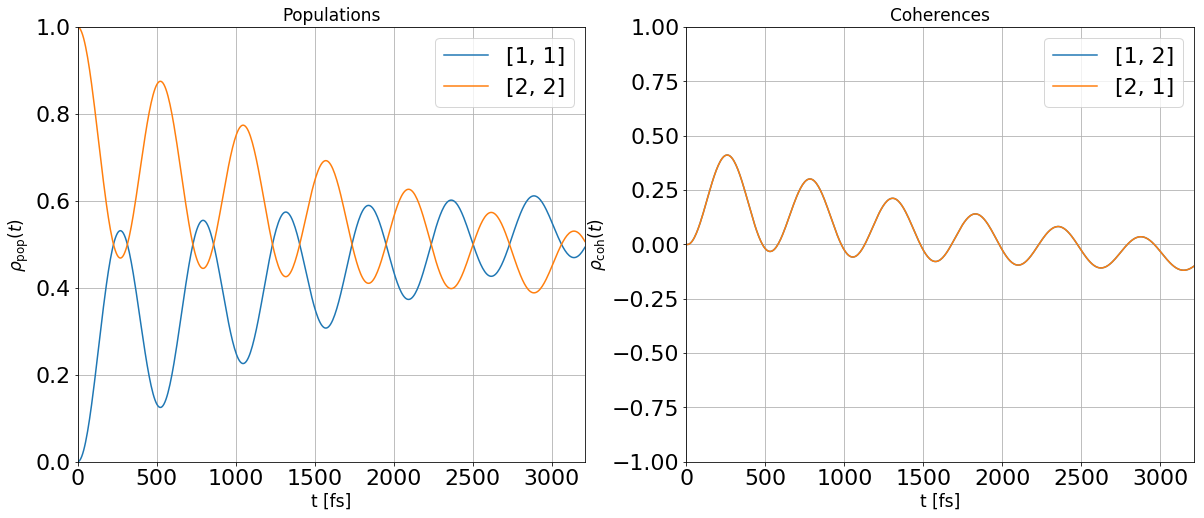

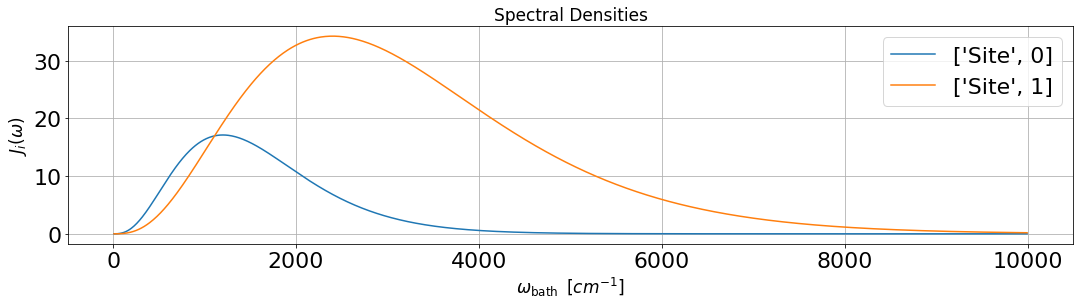

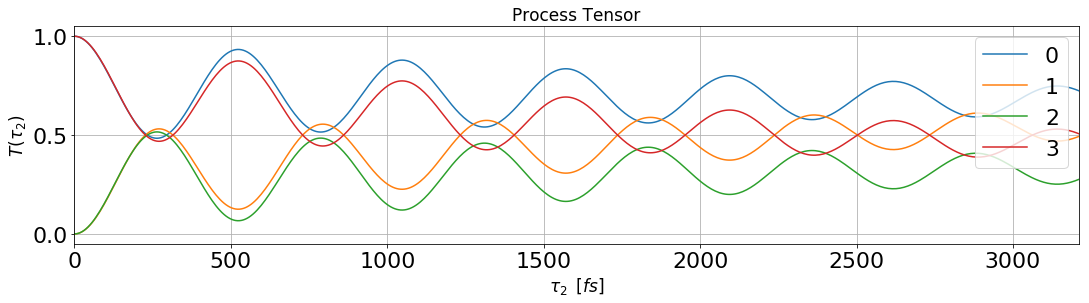

In [14]:
omega_c = np.array([400,800]);
gamma_i = np.array([0.1,0.1])
theta = 20;
M = 2
pos,posv = pop_pos(M)
Rtot,JJ,omega_batch = RedfieldTensor(omega_c,gamma_i,H_S,t,theta)
Rexc = np.reshape(Rtot,(M**2,M**2))
Rsite = VSS@Rexc@VSST
rho_exc,rho_site = RK4_integrate_rho(Rtot,H_S,t,rho0_site)
TM,Ev = TM_matrix(Rsite,t,1); TMpop  = np.squeeze(TM[pos,:]);
plot_rho(taus,omega_bath,rho_exc,JJ,TMpop)